In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#from mpl_toolkits.basemap import Basemap
import seaborn as sns
import os
import tensorflow as tf
from tensorflow import keras
import cartopy


In [2]:
# load data
csv = r'/c/Users/Andrew/Downloads/Fire_Incidents.csv'
fire_df = pd.read_csv(csv)
fire_df.head()

,exposure,incident_address,incident_number,incident_type_desc,property_use,engine_area,call_datetime,dispatch_datetime,arrival_datetime,cleared_datetime,civilian_injury,civilian_fatality,fire_injury,fire_fatality,structure_status,x,y,oid,geom
0,No,2409 TOWNSEND ST,16-0030216,Building fire ...,NaN,E09,2016/09/29 11:46:41+00,2016/09/29 11:49:17+00,2016/09/29 11:55:11+00,2016/09/29 12:54:39+00,0,0,0,0,NaN,-83.005263,42.359048,1,NaN
1,No,7874 FRONTENAC ST,16-0030244,Flood assessment ...,NaN,E09,2016/09/29 13:59:31+00,2016/09/29 14:06:17+00,2016/09/29 14:18:54+00,2016/09/29 14:26:22+00,0,0,0,0,NaN,-83.028054,42.387677,2,NaN
2,No,1881 E GRAND BLVD,16-0030266,Gas leak (natural gas or LPG) ...,NaN,E09,2016/09/29 16:19:25+00,2016/09/29 16:21:32+00,2016/09/29 16:30:24+00,2016/09/29 16:35:53+00,0,0,0,0,NaN,-83.038307,42.374396,3,NaN
3,No,1265 MELDRUM ST,16-0030301,Swift water rescue ...,NaN,E09,2016/09/29 20:57:20+00,2016/09/29 21:00:09+00,2016/09/29 21:04:30+00,2016/09/29 21:17:44+00,0,0,0,0,NaN,-83.011810,42.348770,4,NaN
4,No,17154 LAMONT ST,16-0031935,Building fire ...,NaN,E44,2016/10/12 00:00:14+00,2016/10/12 00:03:20+00,2016/10/12 00:07:08+00,2016/10/12 02:21:52+00,0,0,0,0,NaN,-83.053816,42.419416,5,NaN


In [3]:
# clean/transform data
# long = x, lat = y
fire_df['injury_or_fatality'] = fire_df.apply(lambda x: 1 if (x['civilian_injury'] > 0) | 
                                (x['civilian_fatality'] > 0) | (x['fire_injury'] > 0) |
                                (x['fire_fatality'] > 0) else 0, axis=1)

fire_df.dropna(subset=['x', 'y'], inplace=True)
fire_df['call_datetime'] = pd.to_datetime(fire_df['call_datetime'])
cols = ['injury_or_fatality','call_datetime', 'x', 'y']
fire_df = fire_df[cols]

In [42]:
#update feature columns
fire_df['count'] = 1
fire_df['hour'] = fire_df['call_datetime'].dt.hour
fire_df['day'] = fire_df['call_datetime'].dt.day
fire_df['DoY'] = fire_df['call_datetime'].dt.dayofyear
fire_df['DoW'] = fire_df['call_datetime'].dt.dayofweek
fire_df['week'] = fire_df['call_datetime'].dt.isocalendar().week
fire_df['month'] = fire_df['call_datetime'].dt.month
fire_df['year'] = fire_df['call_datetime'].dt.year
fire_df['weekend'] = fire_df['DoW'].apply(lambda x: 1 if (x == 0) | (x == 6) else 0)

numPeriods = {'hour': 24, 'day': 31, 'DoY': 365, 'DoW': 7, 'week': 53, 'month': 12}
for colName in ['hour','day','DoY','DoW','week','month']:
    fire_df[colName + 'x'] = np.sin(2 * np.pi * fire_df[colName] / numPeriods[colName])
    fire_df[colName + 'y'] = np.cos(2 * np.pi * fire_df[colName] / numPeriods[colName])

fatal = fire_df[fire_df['injury_or_fatality'] == 1]
dfs = {'fatal': fatal, 'all': fire_df}
fire_df.head()


,injury_or_fatality,call_datetime,x,y,hour,day,DoY,DoW,week,month,...,dayy,DoYx,DoYy,DoWx,DoWy,weekx,weeky,monthx,monthy,count
0,0,2016-09-29 11:46:41+00:00,-83.005263,42.359048,11,29,273,3,39,9,...,0.918958,-0.999917,-0.012910,0.433884,-0.900969,-0.99605,-0.088796,-1.000000,-1.836970e-16,1
1,0,2016-09-29 13:59:31+00:00,-83.028054,42.387677,13,29,273,3,39,9,...,0.918958,-0.999917,-0.012910,0.433884,-0.900969,-0.99605,-0.088796,-1.000000,-1.836970e-16,1
2,0,2016-09-29 16:19:25+00:00,-83.038307,42.374396,16,29,273,3,39,9,...,0.918958,-0.999917,-0.012910,0.433884,-0.900969,-0.99605,-0.088796,-1.000000,-1.836970e-16,1
3,0,2016-09-29 20:57:20+00:00,-83.011810,42.348770,20,29,273,3,39,9,...,0.918958,-0.999917,-0.012910,0.433884,-0.900969,-0.99605,-0.088796,-1.000000,-1.836970e-16,1
4,0,2016-10-12 00:00:14+00:00,-83.053816,42.419416,0,12,286,2,41,10,...,-0.758758,-0.977848,0.209315,0.974928,-0.222521,-0.98904,0.147647,-0.866025,5.000000e-01,1


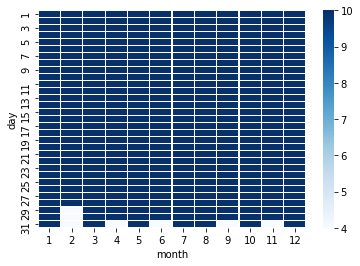

In [21]:
which_df = 'all' #use this to switch betwwen fatal/all incidents
full_years = dfs[which_df].copy()
full_years = full_years[(full_years['year'] > 2016) & (full_years['year'] < 2020) ]
fire_month_day = full_years.copy()
fire_month_day = fire_month_day.groupby(['month', 'day']).count()
fire_month_day = fire_month_day['x'].unstack(level=0)
fire_month_day.fillna(0, inplace=True) #months don't have equal days
ax = sns.heatmap(fire_month_day, cmap="Blues", vmin=4, vmax=10, linewidth=.3)


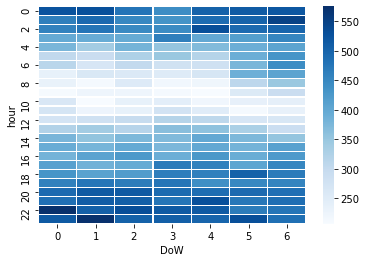

In [22]:
fire_hour_day = full_years.copy()
fire_hour_day = fire_hour_day.groupby(['DoW', 'hour']).count()
fire_hour_day = fire_hour_day['x'].unstack(level=0)
#plt.figize(50,50)
ax = sns.heatmap(fire_hour_day, cmap="Blues", linewidth=.3)

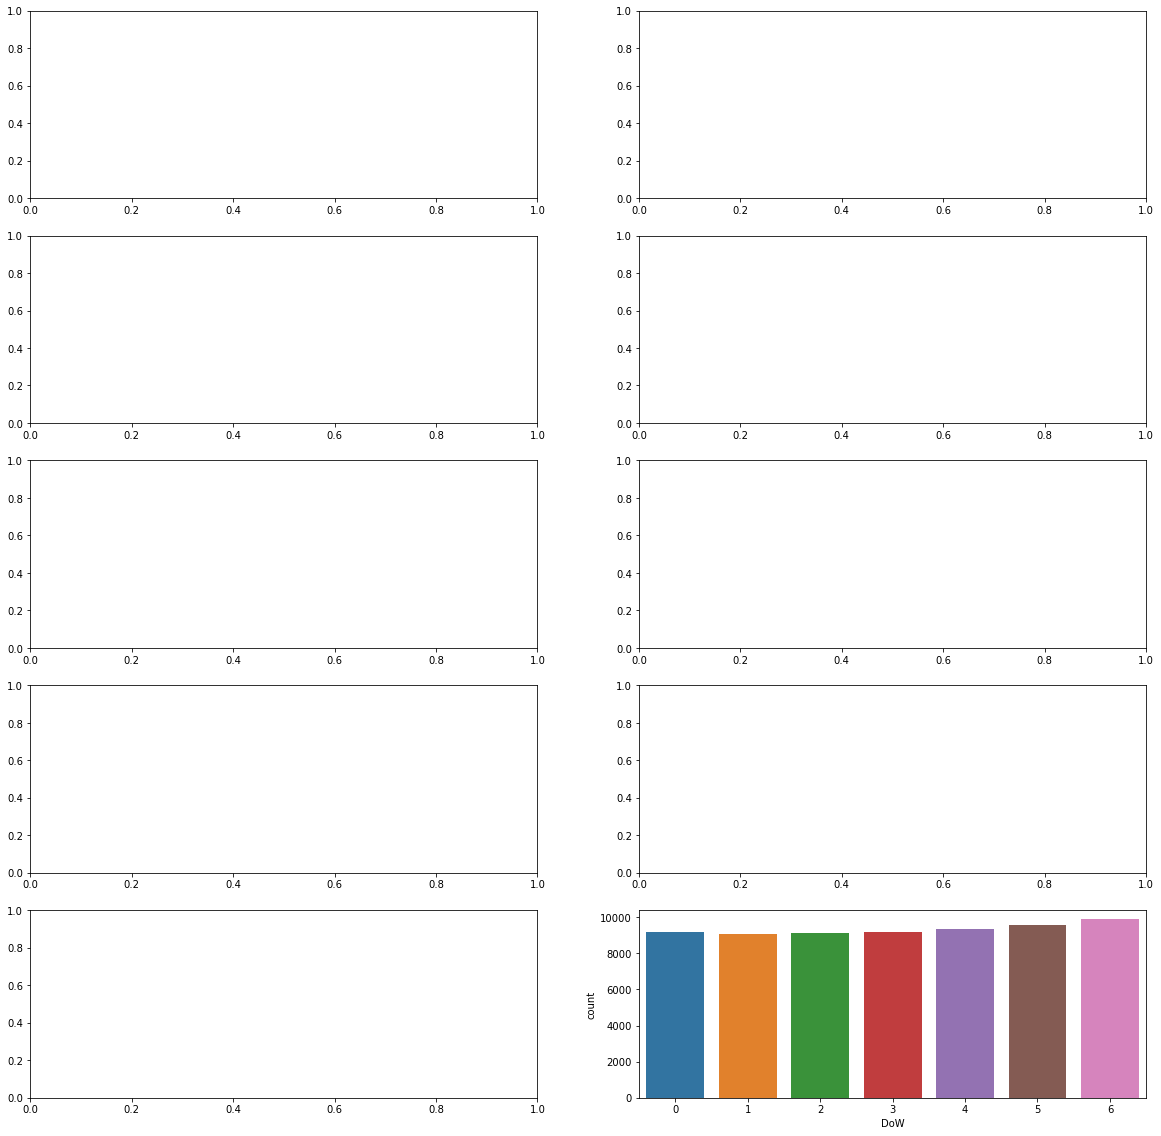

In [41]:
cats = ['hour', 'day', 'DoW', 'week', 'month']
fig, axs = plt.subplots(len(cats),2, figsize=(20,20))
axs[4,1] = sns.countplot(x='DoW', data=full_years)

In [ ]:
timeFeature = 'hour'
bins = [x for x in range(0,numPeriods[timeFeature] + 2)]
plt.subplot(121)
plt.hist(fire_df[timeFeature], bins = bins)
plt.subplot(122)
plt.hist(fatal[timeFeature], bins = bins)

In [8]:
epss = .0012
min_sampless = 5

lat_lon = fire_df[['y', 'x']].values
incident_cluster = DBSCAN(eps=epss, min_samples=min_sampless, metric='euclidean').fit(lat_lon)
fire_df['incident_cluster'] = incident_cluster.labels_.tolist()


In [44]:
#Kmeans clustering
CLUSTERS = 43  # num of fire stations in city
k_clusters = KMeans(CLUSTERS)
k_clusters.fit(fire_df[['y', 'x']])
fire_df['kmeans_cluster'] = k_clusters.predict(fire_df[['y', 'x']])

In [50]:
k_clusters.cluster_centers_[:,0]

array([42.38925945, 32.0263642 , 42.40175658, 42.40481594, 42.35718739,
       42.27330251, 42.4343962 , 42.35797278, 42.43284777, 42.30691243,
       42.43125923, 42.39848747, 42.36290031, 42.43690538, 42.36928178,
       42.4351322 , 42.33353176, 42.35995021, 42.33003859, 42.43494832,
       42.39866457, 42.39562816, 42.43345906, 42.33900528, 42.35705863,
       42.41134217, 42.34551705, 42.34179752, 42.44160623, 42.42675819,
       42.41979199, 42.37201783, 42.41558176, 42.4295928 , 42.41281326,
       42.39706029, 42.40500668, 42.37767805, 42.36528193, 42.37336351,
       42.39252585, 42.38056374, 42.42481002])

In [ ]:
epss = .015
min_sampless = 5
lat_lon = fatal[['y', 'x']].values
fatal_cluster = DBSCAN(eps=epss, min_samples=min_sampless, metric='euclidean').fit(lat_lon)
fatal['fatal_cluster'] = fatal_cluster.labels_.tolist()
#fire_df['cluster'] = fatal_cluster.labels_.tolist()

In [ ]:
#fatal['cluster'].unique()
#lat_lon
#fatal.groupby('cluster').count()
col_name = 'kmeans_cluster' #'incident_cluster'
clusters = fire_df[col_name].unique()
clusters = fire_df.groupby('incident_cluster').count()['exposure']
top_clusters = clusters.sort_values(ascending=False)[0:20].index.values
top_clusters
#plt.plot(clusters)

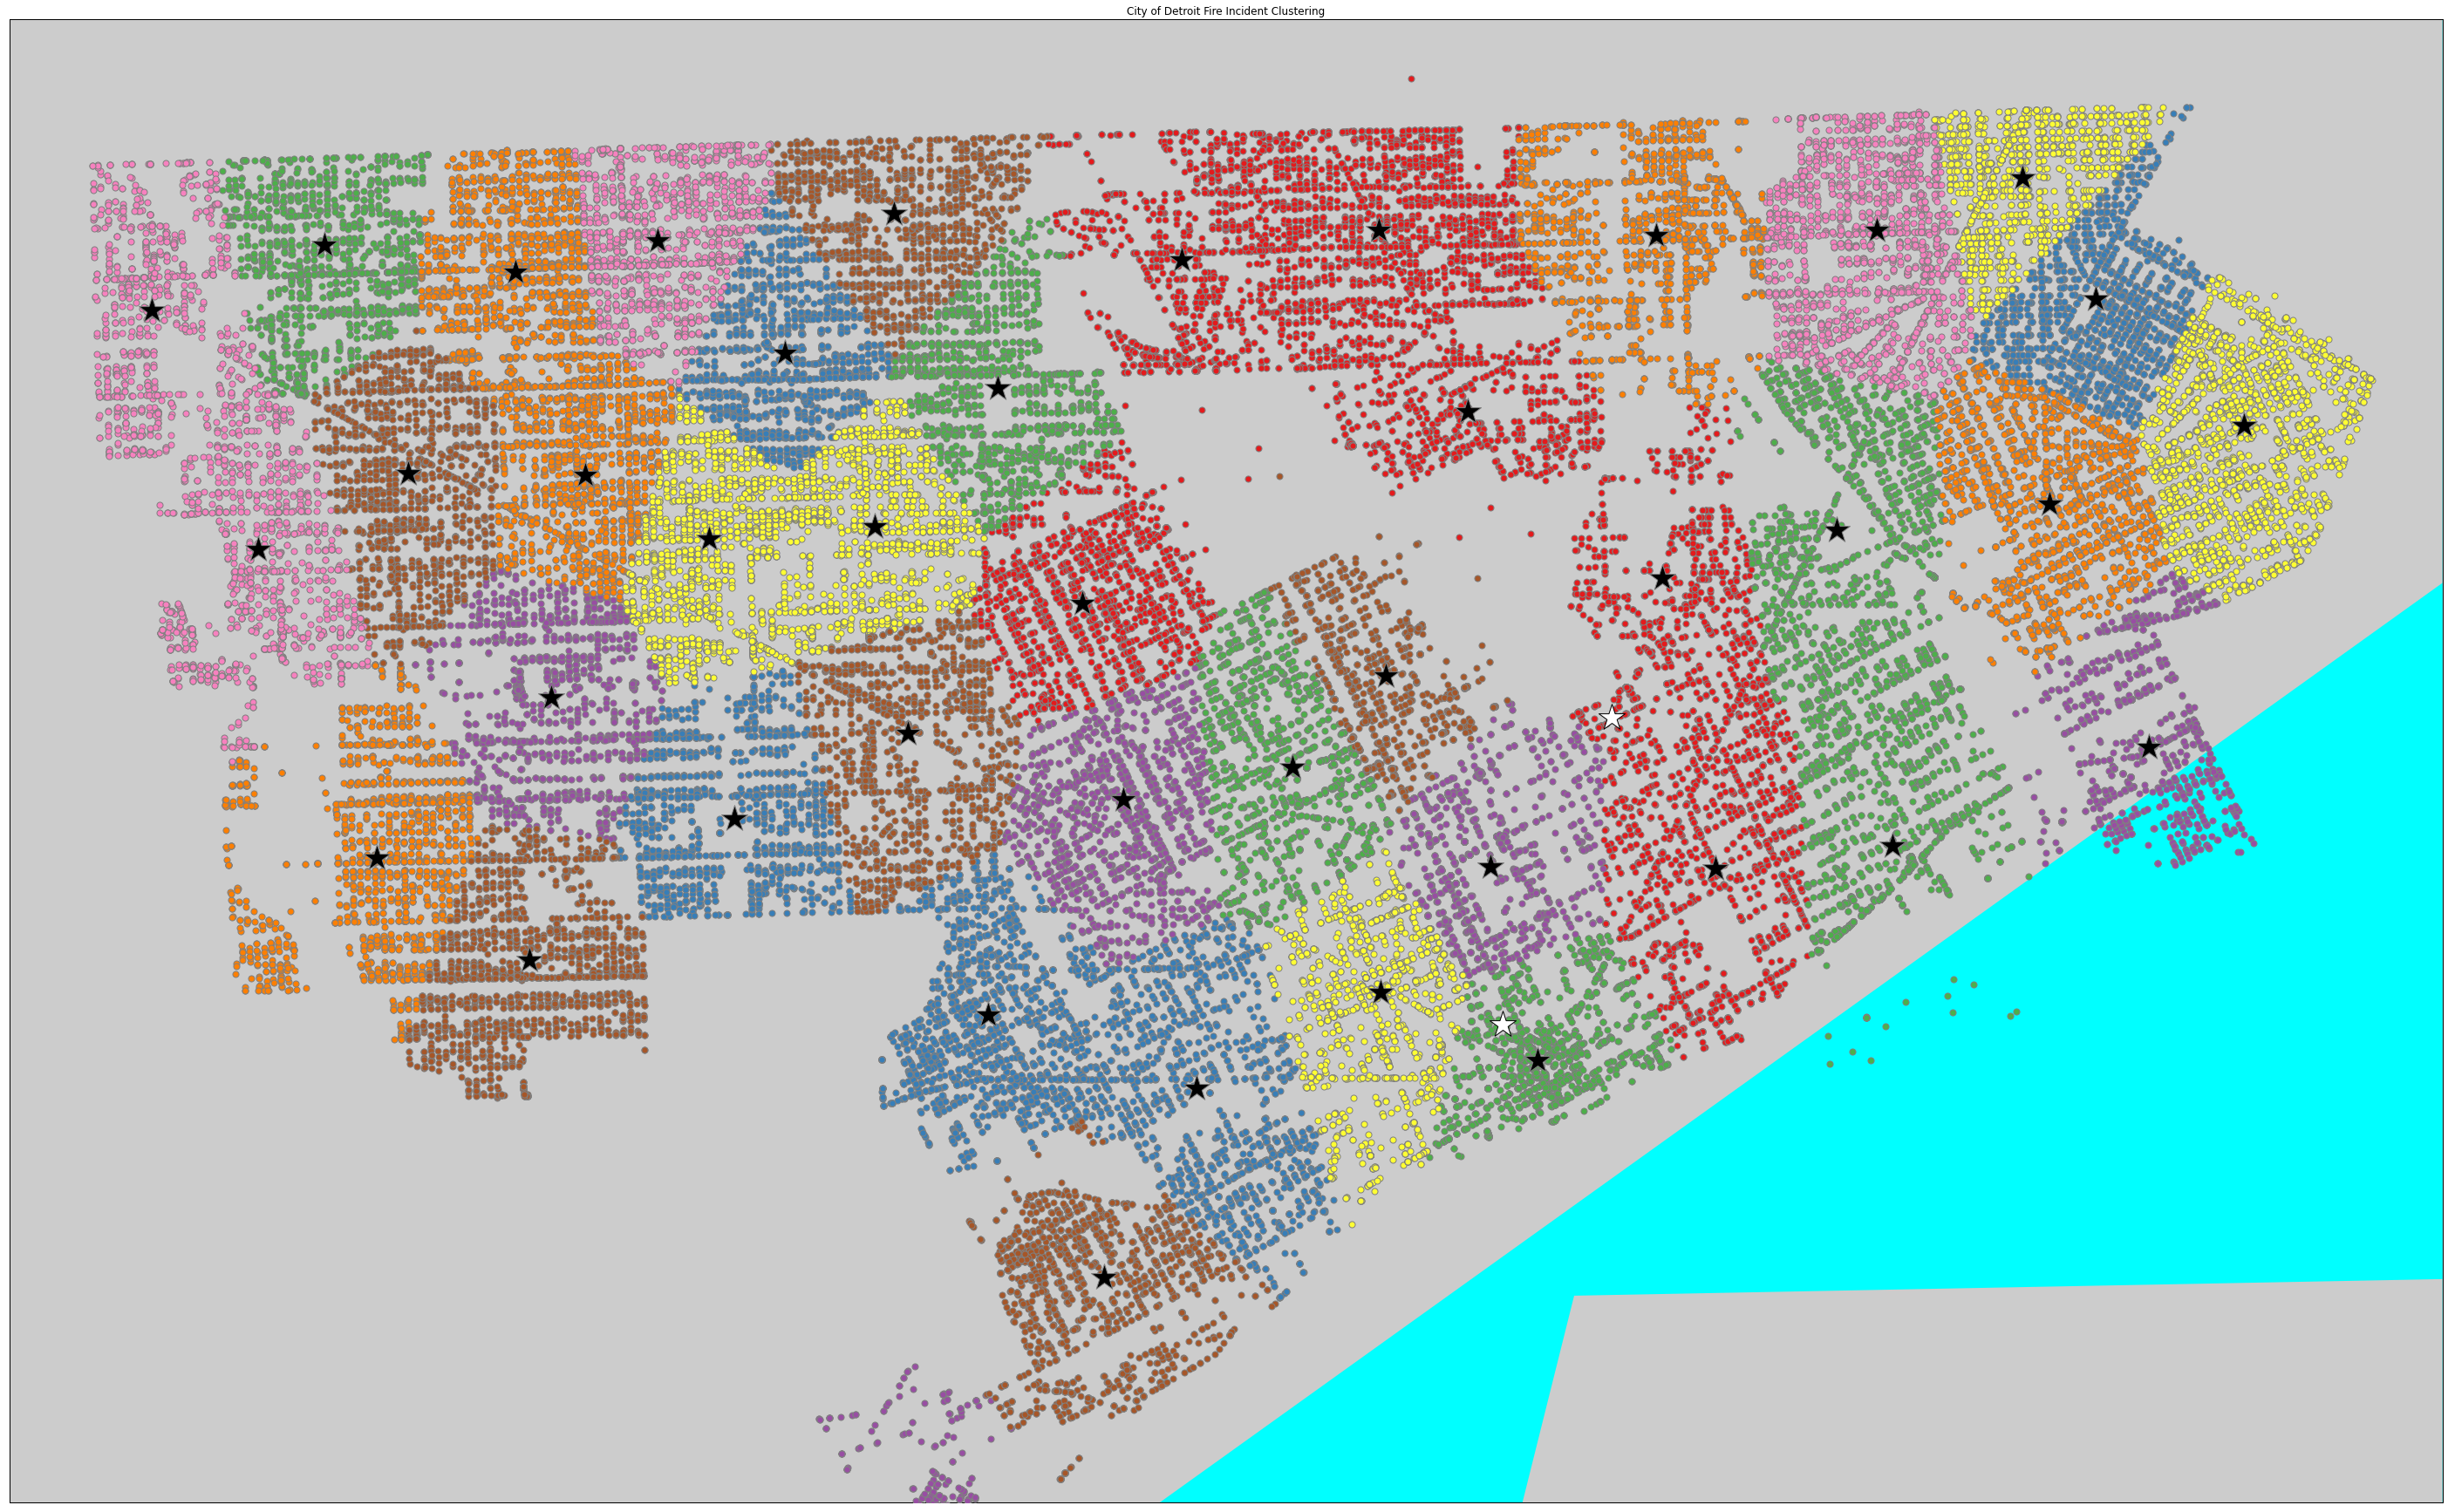

In [70]:
fig, ax = plt.subplots(figsize=(50,50)) #(n2, n1, n1*j+i+1)
ax.set_title("City of Detroit Fire Incident Clustering")
#        ax.set_title("DBSCAN ('greatCircle', eps={}, min_sample={})".format(eps[i], min_sample[j]))
plot_fires_map(ax, fire_df, 'kmeans_cluster', pd.Series(dtype='int'), k_clusters.cluster_centers_ )
#plt.savefig('/home/aheldrich/Website/personal_website/static/fire_incident')

In [16]:
# training
RANDOM_STATE = 111
X = fire_df.iloc[:,11:]
Y = fire_df['injury_or_fatality']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=RANDOM_STATE)

C = .01
linModel = LogisticRegression(random_state=RANDOM_STATE, C=C, penalty='l1', solver='liblinear')
linModel.fit(X_train, Y_train)
Y_pred = linModel.predict(X_train)
print(linModel.score(X_test, Y_test))
print(metrics.confusion_matrix(Y_train, Y_pred))

dummyModel = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummyModel.fit(X_train, Y_train)
print(dummyModel.score(X_test, Y_test))

0.988593345287906
[[59628     0]
 [  599     0]]
0.988593345287906


In [31]:
nn = tf.keras.models.Sequential()
nn.add(keras.layers.Dense(200, activation='relu', input_shape = X_train.shape[-1:]))
nn.add(keras.layers.Dense(100, activation='relu'))
nn.add(keras.layers.Dense(10, activation='relu'))
nn.add(keras.layers.Dense(1, activation='relu'))
nn.compile(optimizer = 'adam'
            , loss='binary_crossentropy', metrics='accuracy')
EPOCHS = 2
nn.fit(X_train,Y_train, epochs=EPOCHS)

Epoch 1/2
1883/1883 [==============================] - 7s 4ms/step - loss: 0.1534 - accuracy: 0.9901
Epoch 2/2
1883/1883 [==============================] - 7s 4ms/step - loss: 0.1534 - accuracy: 0.9901


In [30]:
X_train.shape[-2:]

(60227, 14)

In [ ]:
t = X_test.iloc[0]
linModel.predict(np.array(t).reshape(1,-1))

In [69]:
def plot_fires_map(ax, incidents, columnName, clusterList, kClusters):
    # determine range to print based on min, max lat and lon of the data
    lat = list(incidents['y'])
    lon = list(incidents['x'])
    margin = .001 # buffer to add to the range
    lat_min = 42.28 - margin #min(lat) - margin
    lat_max = 42.46 + margin #max(lat) + margin
    lon_min = -83.3 - margin #min(lon) - margin
    lon_max = -82.9 + margin #max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'l',)

    #m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    if clusterList.any():
        clist = list(clusterList)
    else:
        clist = list(incidents[columnName].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(50, k))))
    for i in range(k):
        color = next(colors)
        df = incidents.loc[incidents[columnName] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['x']), list(df['y']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=50)
        
    klons, klats = m(list(kClusters[:,1]), list(kClusters[:,0]))
    ax.scatter(klons, klats, marker = '*', color='black', edgecolor='gray', zorder=5, alpha=1.0, s=1000)
    
    stnListLon = [-83.054160, -83.036244]
    stnListLat = [42.337962, 42.375536]
    
    stnlons, stnlats = m(stnListLon, stnListLat)
    ax.scatter(stnlons, stnlats, marker = '*', color='white', edgecolor='black', zorder=5, alpha=1.0, s=1000)